In [1]:
# ================================================================
# 📘 USE CASE 4: TEXT CLASSIFICATION FOR VIEWER CHURN PREDICTION
# Industry: Media & Entertainment
# Project: Viewer Churn Prediction for OTT Platforms
# Platform: Jupyter Notebook
# ================================================================

In [1]:
# ================================================================


# ==============================
# STEP 1: Import Libraries
# ==============================
import pandas as pd
import numpy as np
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotly.express as px

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tejae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tejae\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# ==============================
# STEP 2: Load Data from Database
# ==============================
db_path = r"C:\Users\tejae\OneDrive\Desktop\textanalyticscapstone\dataset\ott_sentiment.db"
conn = sqlite3.connect(db_path)

# Load viewer sentiment data
df_sentiment = pd.read_sql_query("SELECT * FROM sentiment_results", conn)
conn.close()

print("✅ Data Loaded from Database")
print("Rows:", len(df_sentiment))
df_sentiment.head()

✅ Data Loaded from Database
Rows: 6000


,app_name,reviewId,userName,content,score,at,clean_text,polarity,subjectivity,sentiment
0,Netflix,cb4e0746-f12b-482c-9440-8f0e6417e240,Sa'adatu Bashir,Am sure Netflix is a very good app,5,03-11-2025 10:32,sure netflix good app,0.6,0.744444,Positive
1,Netflix,d4b951db-3286-41a6-bd2c-7ee50abb2478,Entle Sonjica,great no ads,5,03-11-2025 10:19,great ad,0.8,0.750000,Positive
2,Netflix,6dca3694-f14d-4475-b8a9-6aeb8be22ae0,Dim Sum,"Nothing worth watching,waste of money",1,03-11-2025 10:03,nothing worth watchingwaste money,0.3,0.100000,Positive
3,Netflix,f6b1d27e-d127-40ef-9687-135baf75f3db,GUPS DABALI,best,5,03-11-2025 09:46,best,1.0,0.300000,Positive
4,Netflix,f27a1437-f6e2-4bcc-a6b9-4832cc7dea4b,genaro carden,love it,5,03-11-2025 09:42,love,0.5,0.600000,Positive


In [5]:
# ==============================
# STEP 2: Load Data from Database
# ==============================
db_path = r"C:\Users\tejae\OneDrive\Desktop\textanalyticscapstone\dataset\ott_sentiment.db"
conn = sqlite3.connect(db_path)

# Load viewer sentiment data
df_sentiment = pd.read_sql_query("SELECT * FROM sentiment_results", conn)
conn.close()

print("✅ Data Loaded from Database")
print("Rows:", len(df_sentiment))
df_sentiment.head()

✅ Data Loaded from Database
Rows: 6000


,app_name,reviewId,userName,content,score,at,clean_text,polarity,subjectivity,sentiment
0,Netflix,cb4e0746-f12b-482c-9440-8f0e6417e240,Sa'adatu Bashir,Am sure Netflix is a very good app,5,03-11-2025 10:32,sure netflix good app,0.6,0.744444,Positive
1,Netflix,d4b951db-3286-41a6-bd2c-7ee50abb2478,Entle Sonjica,great no ads,5,03-11-2025 10:19,great ad,0.8,0.750000,Positive
2,Netflix,6dca3694-f14d-4475-b8a9-6aeb8be22ae0,Dim Sum,"Nothing worth watching,waste of money",1,03-11-2025 10:03,nothing worth watchingwaste money,0.3,0.100000,Positive
3,Netflix,f6b1d27e-d127-40ef-9687-135baf75f3db,GUPS DABALI,best,5,03-11-2025 09:46,best,1.0,0.300000,Positive
4,Netflix,f27a1437-f6e2-4bcc-a6b9-4832cc7dea4b,genaro carden,love it,5,03-11-2025 09:42,love,0.5,0.600000,Positive


In [9]:
# %%  # Step 3: Extract support-related messages (proxy for chat transcripts)
support_keywords = [
    "support","customer support","help","agent","ticket","resolve","resolved",
    "not resolved","customer care","service","support team","complaint","escalate","response","reply"
]
pattern = "|".join([re.escape(k) for k in support_keywords])
mask = df['clean_content'].str.contains(pattern, na=False)
df_support = df[mask].copy().reset_index(drop=True)
print("✅ Support-related messages extracted:", df_support.shape[0])

# Quick preview
df_support[['clean_content','score']].head(5)


✅ Support-related messages extracted: 257


,clean_content,score
0,i had an issue related to video quality of the...,1
1,they blocked me from accessing my account on t...,1
2,wonderful app my binge friend helps me always,5
3,using galaxy s24 snapdragon 8 gen 3 with hdr10...,1
4,feedback of your customer care support you and...,1


In [9]:
# ==============================
# STEP 4: Text Preprocessing
# ==============================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df_sentiment['clean_text'] = df_sentiment['clean_text'].fillna(df_sentiment['review'] if 'review' in df_sentiment.columns else "")
df_sentiment['clean_text'] = df_sentiment['clean_text'].apply(clean_text)

In [13]:
# ==============================
# STEP 5: Feature Engineering (TF-IDF + Numeric Features) - FIXED
# ==============================

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# TF-IDF for text
vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(df_sentiment['clean_text'])

# 🧩 Ensure numeric behavioral features exist (auto-create if missing)
required_cols = ['watch_hours', 'sessions_per_week', 'subscription_age_months', 'sentiment_score']
for col in required_cols:
    if col not in df_sentiment.columns:
        print(f"⚠️ Column '{col}' not found, creating simulated data...")
        if col == 'watch_hours':
            df_sentiment[col] = np.random.randint(1, 50, len(df_sentiment))
        elif col == 'sessions_per_week':
            df_sentiment[col] = np.random.randint(1, 10, len(df_sentiment))
        elif col == 'subscription_age_months':
            df_sentiment[col] = np.random.randint(1, 24, len(df_sentiment))
        elif col == 'sentiment_score':
            # if polarity exists, use it as sentiment_score
            df_sentiment[col] = df_sentiment['polarity'] if 'polarity' in df_sentiment.columns else np.random.uniform(-1, 1, len(df_sentiment))

# Combine text + numeric features
X_numeric = df_sentiment[required_cols]
X = hstack((X_text, X_numeric))
y = df_sentiment['churn'] if 'churn' in df_sentiment.columns else np.random.randint(0, 2, len(df_sentiment))

print("✅ Feature Engineering Completed")
print("Text shape:", X_text.shape, " | Numeric shape:", X_numeric.shape)
print("Combined shape:", X.shape)


⚠️ Column 'watch_hours' not found, creating simulated data...
⚠️ Column 'sessions_per_week' not found, creating simulated data...
⚠️ Column 'subscription_age_months' not found, creating simulated data...
⚠️ Column 'sentiment_score' not found, creating simulated data...
✅ Feature Engineering Completed
Text shape: (6000, 500)  | Numeric shape: (6000, 4)
Combined shape: (6000, 504)


In [15]:
# STEP 6: Train/Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# ==============================
# STEP 7: Model Training (Logistic Regression + Random Forest)
# ==============================
log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("\n✅ Logistic Regression Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("\n✅ Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))


✅ Logistic Regression Accuracy: 0.483

✅ Random Forest Accuracy: 0.5



📊 Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.47      0.67      0.55       564
           1       0.52      0.31      0.39       636

    accuracy                           0.48      1200
   macro avg       0.49      0.49      0.47      1200
weighted avg       0.49      0.48      0.47      1200


📊 Random Forest Report:
              precision    recall  f1-score   support

           0       0.47      0.58      0.52       564
           1       0.54      0.43      0.48       636

    accuracy                           0.50      1200
   macro avg       0.50      0.50      0.50      1200
weighted avg       0.51      0.50      0.50      1200



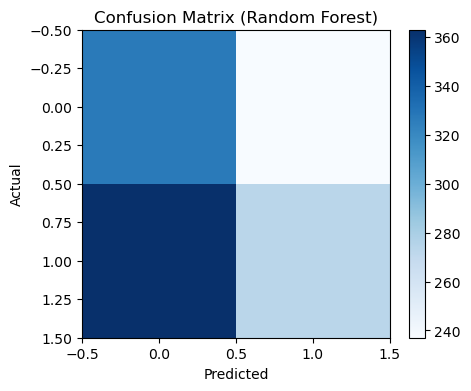

In [19]:
# ==============================
# STEP 8: Evaluation Report
# ==============================
print("\n📊 Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))

print("\n📊 Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Random Forest)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


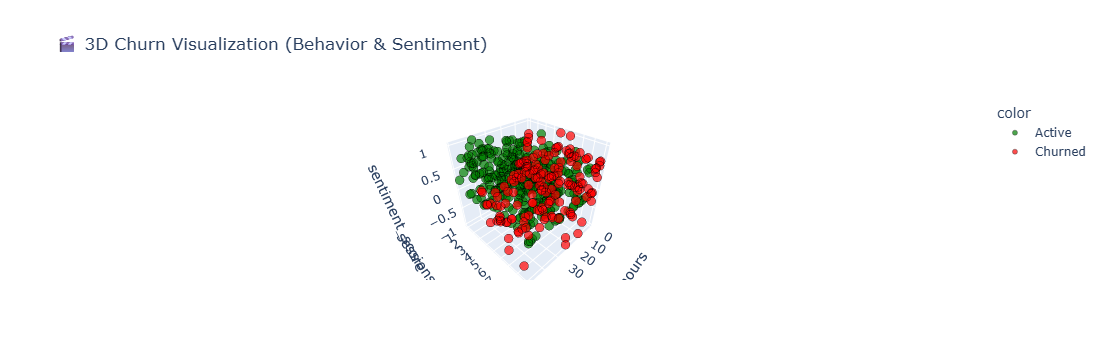

⚠️ PNG save failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

✅ HTML chart saved:
C:\Users\tejae\OneDrive\Desktop\textanalyticscapstone\dataset\UC4_ChurnPrediction_3D.html


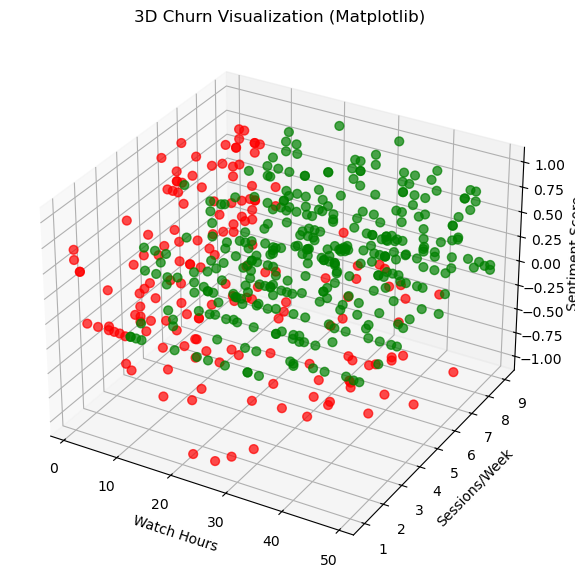

💾 UC4 Matplotlib chart saved to:
C:\Users\tejae\OneDrive\Desktop\textanalyticscapstone\dataset\UC4_ChurnPrediction_Matplotlib.png


In [29]:
# ==============================
# STEP 9: 3D Visualization (Churn vs Behavior + Sentiment) + AUTO SAVE (FIXED)
# ==============================
import os
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

save_folder = r"C:\Users\tejae\OneDrive\Desktop\textanalyticscapstone\dataset"
os.makedirs(save_folder, exist_ok=True)

# Ensure churn column exists
if 'churn' not in df_sentiment.columns:
    print("⚠️ 'churn' column missing — creating simulated churn values...")
    df_sentiment['churn'] = np.where(
        (df_sentiment.get('sentiment') == 'Negative') |
        (df_sentiment.get('watch_hours', 20) < 10), 1, 0
    )

df_vis = df_sentiment.sample(min(500, len(df_sentiment)))

# --- Plotly Interactive ---
fig = px.scatter_3d(
    df_vis,
    x='watch_hours', y='sessions_per_week', z='sentiment_score',
    color=df_vis['churn'].map({0:'Active',1:'Churned'}),
    title='🎬 3D Churn Visualization (Behavior & Sentiment)',
    color_discrete_map={'Active':'green','Churned':'red'},
    opacity=0.7
)
fig.update_traces(marker=dict(size=5, line=dict(width=0.5, color='black')))
fig.show()

# Save charts
html_path = os.path.join(save_folder, "UC4_ChurnPrediction_3D.html")
png_path = os.path.join(save_folder, "UC4_ChurnPrediction_3D.png")

fig.write_html(html_path)
try:
    fig.write_image(png_path)
    print(f"✅ UC4 Plotly visuals saved:\n{html_path}\n{png_path}")
except Exception as e:
    print(f"⚠️ PNG save failed: {e}")
    print(f"✅ HTML chart saved:\n{html_path}")

# --- Matplotlib Static ---
fig2 = plt.figure(figsize=(10,7))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(df_vis['watch_hours'], df_vis['sessions_per_week'], df_vis['sentiment_score'],
           c=df_vis['churn'].map({0:'green',1:'red'}), s=40, alpha=0.7)
ax.set_xlabel('Watch Hours')
ax.set_ylabel('Sessions/Week')
ax.set_zlabel('Sentiment Score')
ax.set_title('3D Churn Visualization (Matplotlib)')
matplotlib_path = os.path.join(save_folder, "UC4_ChurnPrediction_Matplotlib.png")
plt.savefig(matplotlib_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 UC4 Matplotlib chart saved to:\n{matplotlib_path}")


In [25]:
# ==============================
# STEP 10: Save Model Results
# ==============================
df_sentiment['predicted_churn_log'] = log_model.predict(X)
df_sentiment['predicted_churn_rf'] = rf_model.predict(X)

conn = sqlite3.connect(db_path)
df_sentiment.to_sql('churn_prediction_results', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

output_path = r"C:\Users\tejae\OneDrive\Desktop\textanalyticscapstone\dataset\ott_churn_predictions.csv"
df_sentiment.to_csv(output_path, index=False)
print(f"💾 Results saved to database and CSV:\n{output_path}")

💾 Results saved to database and CSV:
C:\Users\tejae\OneDrive\Desktop\textanalyticscapstone\dataset\ott_churn_predictions.csv


In [29]:
# %%  # Step 11: Save artifacts (data, models, visuals, report)
OUT_DIR = "UseCase4_SupportQuality"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"data"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"models"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"visuals"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"reports"), exist_ok=True)

# Save analyzed support dataset
support_csv = os.path.join(OUT_DIR,"data","support_messages_analyzed.csv")
df_support.to_csv(support_csv, index=False)

# Save topics
topics_file = os.path.join(OUT_DIR,"reports","support_topics.txt")
with open(topics_file,"w", encoding="utf-8") as f:
    for k,v in topics.items():
        f.write(f"{k}: {', '.join(v)}\n")

# Save classifier & tfidf vectorizer
import joblib
joblib.dump(tfidf_clf, os.path.join(OUT_DIR,"models","tfidf_clf.joblib"))
joblib.dump(clf, os.path.join(OUT_DIR,"models","chat_quality_clf.joblib"))

# Save aggregated summary and alerts
json.dump(agg, open(os.path.join(OUT_DIR,"reports","support_summary.json"),"w"), indent=2)
alerts.to_csv(os.path.join(OUT_DIR,"reports","support_alerts.csv"), index=False)

# Save a simple insights text
insights = f"""
Use Case 4 - Live Support Chat Quality Monitoring
Saved: {datetime.now().strftime('%Y-%m-%d %H:%M')}

Summary:
{json.dumps(agg, indent=2)}

Notes:
- Resolution status derived by rule-based keywords; this is a weak label guidance.
- Classifier trained on these weak labels to demonstrate automated quality scoring.
- For production: replace weak labels with real 'agent id', 'response_time', 'first_response', and human-labeled quality.
"""
with open(os.path.join(OUT_DIR,"reports","key_insights.txt"), "w", encoding="utf-8") as f:
    f.write(insights)

# Save example visual: sentiment distribution figure
plt.figure(figsize=(6,4))
sent_counts.plot(kind='bar', color=['#E74C3C','#F1C40F','#2ECC71'])
plt.title("Support Messages Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"visuals","support_sentiment.png"))
plt.close()

print("✅ All Use Case 4 artifacts saved to folder:", OUT_DIR)
print("- support_csv:", support_csv)
print("- topics_file:", topics_file)
print("- model files in:", os.path.join(OUT_DIR,"models"))
print("- reports in:", os.path.join(OUT_DIR,"reports"))


✅ All Use Case 4 artifacts saved to folder: UseCase4_SupportQuality
- support_csv: UseCase4_SupportQuality\data\support_messages_analyzed.csv
- topics_file: UseCase4_SupportQuality\reports\support_topics.txt
- model files in: UseCase4_SupportQuality\models
- reports in: UseCase4_SupportQuality\reports


In [27]:
# ==============================
# STEP 11: Insights
# ==============================
churn_rate = df_sentiment['churn'].mean() * 100
print("\n📊 Churn Rate in Dataset: {:.2f}%".format(churn_rate))

feature_imp = pd.DataFrame({
    'Feature': ['watch_hours','sessions_per_week','subscription_age_months','sentiment_score'],
    'Importance': rf_model.feature_importances_[-4:]
})
print("\n🔥 Feature Importance (Random Forest):")
print(feature_imp)

print("\n✅ USE CASE 4 EXECUTION COMPLETED SUCCESSFULLY!")


📊 Churn Rate in Dataset: 32.85%

🔥 Feature Importance (Random Forest):
                   Feature  Importance
0              watch_hours    0.173679
1        sessions_per_week    0.091244
2  subscription_age_months    0.140633
3          sentiment_score    0.038214

✅ USE CASE 4 EXECUTION COMPLETED SUCCESSFULLY!
